### **Старт, базовые штуки и загрузка библиотек**

In [ ]:
import zipfile

with zipfile.ZipFile('/content/edm-main.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/edm-main')

In [ ]:
import sys
sys.path.append(r'/content/edm-main/edm-main/')

In [ ]:
import tqdm
import pickle
import numpy as np
import torch
import PIL.Image
import dnnlib
import os
from torchvision import datasets
import torchvision.transforms as transforms

In [ ]:
pip install pytorch_fid

In [ ]:
import shutil
import subprocess
import tempfile
import random

from pytorch_fid.fid_score import calculate_fid_given_paths

### **Скачивание датасета Cifar10**

In [ ]:
def download_cifar10_images(dest_dir='cifar10_images'):
    os.makedirs(dest_dir, exist_ok=True)
    transform = transforms.ToPILImage()
    dataset = datasets.CIFAR10(root='./data', train=False, download=True)

    for idx, (image, _) in enumerate(dataset):
        image.save(os.path.join(dest_dir, f'image_{idx:04d}.png'))

    print(f'CIFAR-10 images saved to {dest_dir}')

download_cifar10_images()

Files already downloaded and verified
CIFAR-10 images saved to cifar10_images


In [ ]:
dataset_dir = 'cifar10_images'

### **Генератор изображений по батчу**

In [ ]:
torch.manual_seed(52)

In [ ]:
def get_next_index(dest_dir):
    """Finds the next available image index in the destination directory."""
    existing_files = [f for f in os.listdir(dest_dir) if f.startswith('image_') and f.endswith('.png')]
    if existing_files:
        indices = [int(f.split('_')[1].split('.')[0]) for f in existing_files]
        return max(indices) + 1
    else:
        return 0

In [ ]:
def sample_images_batch(
    net, dest_path, hoen = True,
    seed=42, batch_size = 100, device=torch.device('cuda'),
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
    start_index = 0
):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    # Рассчитываем временные шаги
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    # Нулевой шаг в конец (t_{N})
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    latents = torch.randn([batch_size, net.img_channels, net.img_resolution, net.img_resolution], device=device)

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]  # Шаг 1
    for i, (t_cur, t_next) in list(enumerate(zip(t_steps[:-1], t_steps[1:]))): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily. // увеличение шума
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * torch.randn_like(x_cur)

        # Euler step. // убрал классы так как у нас анконд
        denoised = net(x_hat, t_hat).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction. // Hoen //  убрал классы так как у нас анконд
        if hoen == True:
            if i < num_steps - 1:
                denoised = net(x_next, t_next).to(torch.float64)
                d_prime = (x_next - denoised) / t_next
                x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

    images = (x_next * 127.5 + 128).clip(0, 255).to(torch.uint8).cpu()
    for idx, image in enumerate(images):
        img = image.permute(1, 2, 0).numpy()
        img = PIL.Image.fromarray(img, 'RGB')
        img.save(os.path.join(dest_dir, f'image_{start_index+idx}.png'))

### **Генератор изображений и разбиение изображений на сабсеты**

In [ ]:
def generate_required_images(
    net, required_images, num_steps, dest_dir, hoen,
    batch_size=100, seed=42, device=torch.device('cuda')
):
    os.makedirs(dest_dir, exist_ok=True)

    n_runs = required_images//batch_size

    for i in tqdm.tqdm(range (n_runs)):
        generated_images = get_next_index(dest_dir)
        sample_images_batch(
            net, dest_dir, hoen,
            batch_size=batch_size, device=device, num_steps=num_steps,
            start_index=generated_images
        )

### **Расчет фида**

In [ ]:
def create_subsets(input_dir, output_dir, counts):
    for count in counts:
        subset_dir = os.path.join(output_dir, f"subset_{count}")
        os.makedirs(subset_dir, exist_ok=True)

        all_files = sorted(os.listdir(input_dir))[:count]
        for file_name in all_files:
            full_file_name = os.path.join(input_dir, file_name)
            if os.path.isfile(full_file_name):
                shutil.copy(full_file_name, subset_dir)

def calculate_fid_for_subsets(dataset_dir, output_dir, counts, batch_size=100,
                              device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
                              dims=2048, num_workers=12, dataset_sabsets_usage = True):
    fid_values = []
    for count in counts:
        subset_dir_output = os.path.join(output_dir, f"subset_{count}")
        if dataset_sabsets_usage==True:
            subset_dir_dataset = os.path.join(dataset_dir, f"subset_{count}")
        else:
            subset_dir_dataset = dataset_dir

        fid = calculate_fid_given_paths(
            [subset_dir_output, subset_dir_dataset],
            batch_size=batch_size,
            device=device,
            dims=dims,
            num_workers=num_workers)
        fid_values.append(fid)
    return fid_values

In [ ]:
create_subsets(dataset_dir, dataset_dir, [50000])

### **Сборка и запуск генератора и расчета фида**

In [ ]:
network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-uncond-vp.pkl'

with dnnlib.util.open_url(network_pkl) as f:
    net = pickle.load(f)['ema'].to(torch.device('cuda'))

In [ ]:
num_steps_list = [10, 20, 30, 50]

fid_values_Eiler_full_dataset_list = []
fid_values_Eiler_sabset_dataset_list = []

fid_values_Hoen_full_dataset_list = []
fid_values_Hoen_sabset_dataset_list = []

for num_steps in num_steps_list:
    print(f'clculating for {num_steps} steps')

    dest_dir = f'gen_images_Eiler_{num_steps}'
    generate_required_images(net, 50000, num_steps, dest_dir, False, batch_size = 2000)
    create_subsets(dest_dir, dest_dir, [50000])

    fid_values_Eiler_full_dataset = calculate_fid_for_subsets(dataset_dir, dest_dir, [50000], dataset_sabsets_usage = False)
    fid_values_Eiler_full_dataset_list.append(fid_values_Eiler_full_dataset)
    print(f'fid for Eiler full dataset: {fid_values_Eiler_full_dataset}')

    fid_values_Eiler_sabset_dataset = calculate_fid_for_subsets(dataset_dir, dest_dir, [50000], dataset_sabsets_usage = True)
    fid_values_Eiler_sabset_dataset_list.append(fid_values_Eiler_sabset_dataset)
    print(f'fid for Eiler sabset dataset: {fid_values_Eiler_sabset_dataset}')

    with zipfile.ZipFile(f'{dest_dir}.zip', 'w') as zipf:
        for root, _, files in os.walk(dest_dir):
            for file in files:
                zipf.write(os.path.join(root, file), file)

    dest_dir = f'gen_images_Hoen_{num_steps}'
    generate_required_images(net, 50000, num_steps, dest_dir, True, batch_size = 2000)
    create_subsets(dest_dir, dest_dir, [50000])

    fid_values_Hoen_full_dataset = calculate_fid_for_subsets(dataset_dir, dest_dir, [50000], dataset_sabsets_usage = False)
    fid_values_Hoen_full_dataset_list.append(fid_values_Hoen_full_dataset)
    print(f'fid for Hoen full dataset: {fid_values_Hoen_full_dataset}')


    fid_values_Hoen_sabset_dataset = calculate_fid_for_subsets(dataset_dir, dest_dir, [50000], dataset_sabsets_usage = True)
    fid_values_Hoen_sabset_dataset_list.append(fid_values_Hoen_sabset_dataset)
    print(f'fid for Hoen sabset dataset: {fid_values_Hoen_sabset_dataset}')

    # Create ZIP for Hoen
    with zipfile.ZipFile(f'{dest_dir}.zip', 'w') as zipf:
        for root, _, files in os.walk(dest_dir):
            for file in files:
                zipf.write(os.path.join(root, file), file)

clculating for 10 steps


100%|██████████| 100/100 [00:05<00:00, 19.07it/s]


fid for Eiler full dataset: [21.27304551901983]


100%|██████████| 100/100 [00:05<00:00, 18.76it/s]


fid for Eiler sabset dataset: [21.27304551901983]


Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/lib/python3.10/zipfile.py:1528: UserWarning: Duplicate name: 'image_48285.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.10/zipfile.py:1528: UserWarning: Duplicate name: 'image_3739.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.10/zipfile.py:1528: UserWarning: Duplicate name: 'image_10377.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.10/zipfile.py:1528: UserWarning: Duplicate name: 'image_49170.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.10/zipfile.py:1528: UserWarning: Duplicate name: 'image_33108.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.10/zipfile.py:1528: UserWarning: Duplicate name: 'image_22283.png'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/usr/lib/python3.10/zipfile.py:1528: UserWarning: Duplicate nam

fid for Hoen full dataset: [4.874457315149471]


100%|██████████| 100/100 [00:05<00:00, 19.06it/s]


fid for Hoen sabset dataset: [4.874457315149471]
clculating for 20 steps


100%|██████████| 100/100 [00:05<00:00, 18.10it/s]


fid for Eiler full dataset: [8.829072797287324]


100%|██████████| 100/100 [00:05<00:00, 18.96it/s]


fid for Eiler sabset dataset: [8.829072797287324]


100%|██████████| 100/100 [00:05<00:00, 19.03it/s]


fid for Hoen full dataset: [4.155084641681583]


100%|██████████| 100/100 [00:05<00:00, 18.92it/s]


fid for Hoen sabset dataset: [4.155084641681583]
clculating for 30 steps


100%|██████████| 100/100 [00:05<00:00, 18.99it/s]


fid for Eiler full dataset: [6.52219291192273]


100%|██████████| 100/100 [00:05<00:00, 18.91it/s]


fid for Eiler sabset dataset: [6.52219291192273]


100%|██████████| 100/100 [00:05<00:00, 19.09it/s]


fid for Hoen full dataset: [4.174577281922836]


100%|██████████| 100/100 [00:05<00:00, 18.97it/s]


fid for Hoen sabset dataset: [4.174577281922836]
clculating for 50 steps


100%|██████████| 100/100 [00:05<00:00, 19.08it/s]


fid for Eiler full dataset: [5.240002383179899]


100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


fid for Eiler sabset dataset: [5.240002383179899]


100%|██████████| 100/100 [00:05<00:00, 18.83it/s]


fid for Hoen full dataset: [4.204482852003707]


100%|██████████| 100/100 [00:05<00:00, 18.70it/s]


fid for Hoen sabset dataset: [4.204482852003707]


### **Отображение результатов**

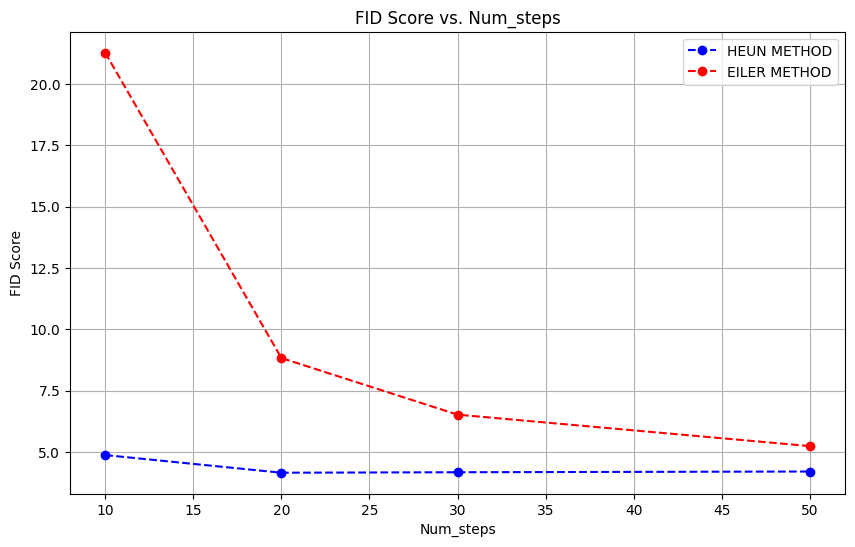

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(num_steps_list, fid_values_Hoen_full_dataset_list, marker='o', linestyle='--', color='b', label='HEUN METHOD')
plt.plot(num_steps_list, fid_values_Eiler_full_dataset_list, marker='o', linestyle='--', color='r', label='EILER METHOD')

plt.xlabel('Num_steps')
plt.ylabel('FID Score')
plt.title('FID Score vs. Num_steps')
plt.grid(True)
plt.legend()

plt.show()

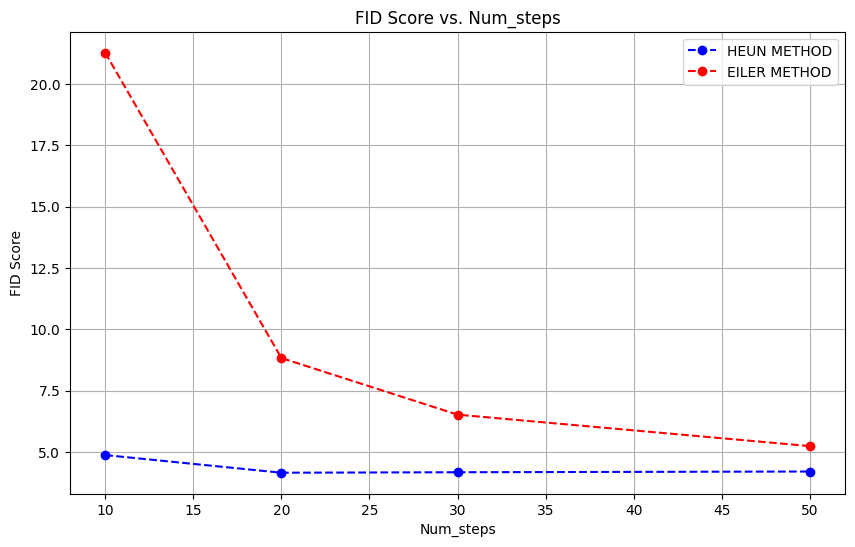

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(num_steps_list, fid_values_Hoen_sabset_dataset_list, marker='o', linestyle='--', color='b', label='HEUN METHOD')
plt.plot(num_steps_list, fid_values_Eiler_sabset_dataset_list, marker='o', linestyle='--', color='r', label='EILER METHOD')

plt.xlabel('Num_steps')
plt.ylabel('FID Score')
plt.title('FID Score vs. Num_steps')
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
fid_values_Hoen_full_dataset_list

[[4.874457315149471],
 [4.155084641681583],
 [4.174577281922836],
 [4.204482852003707]]

In [ ]:
fid_values_Eiler_sabset_dataset_list

[[21.27304551901983],
 [8.829072797287324],
 [6.52219291192273],
 [5.240002383179899]]

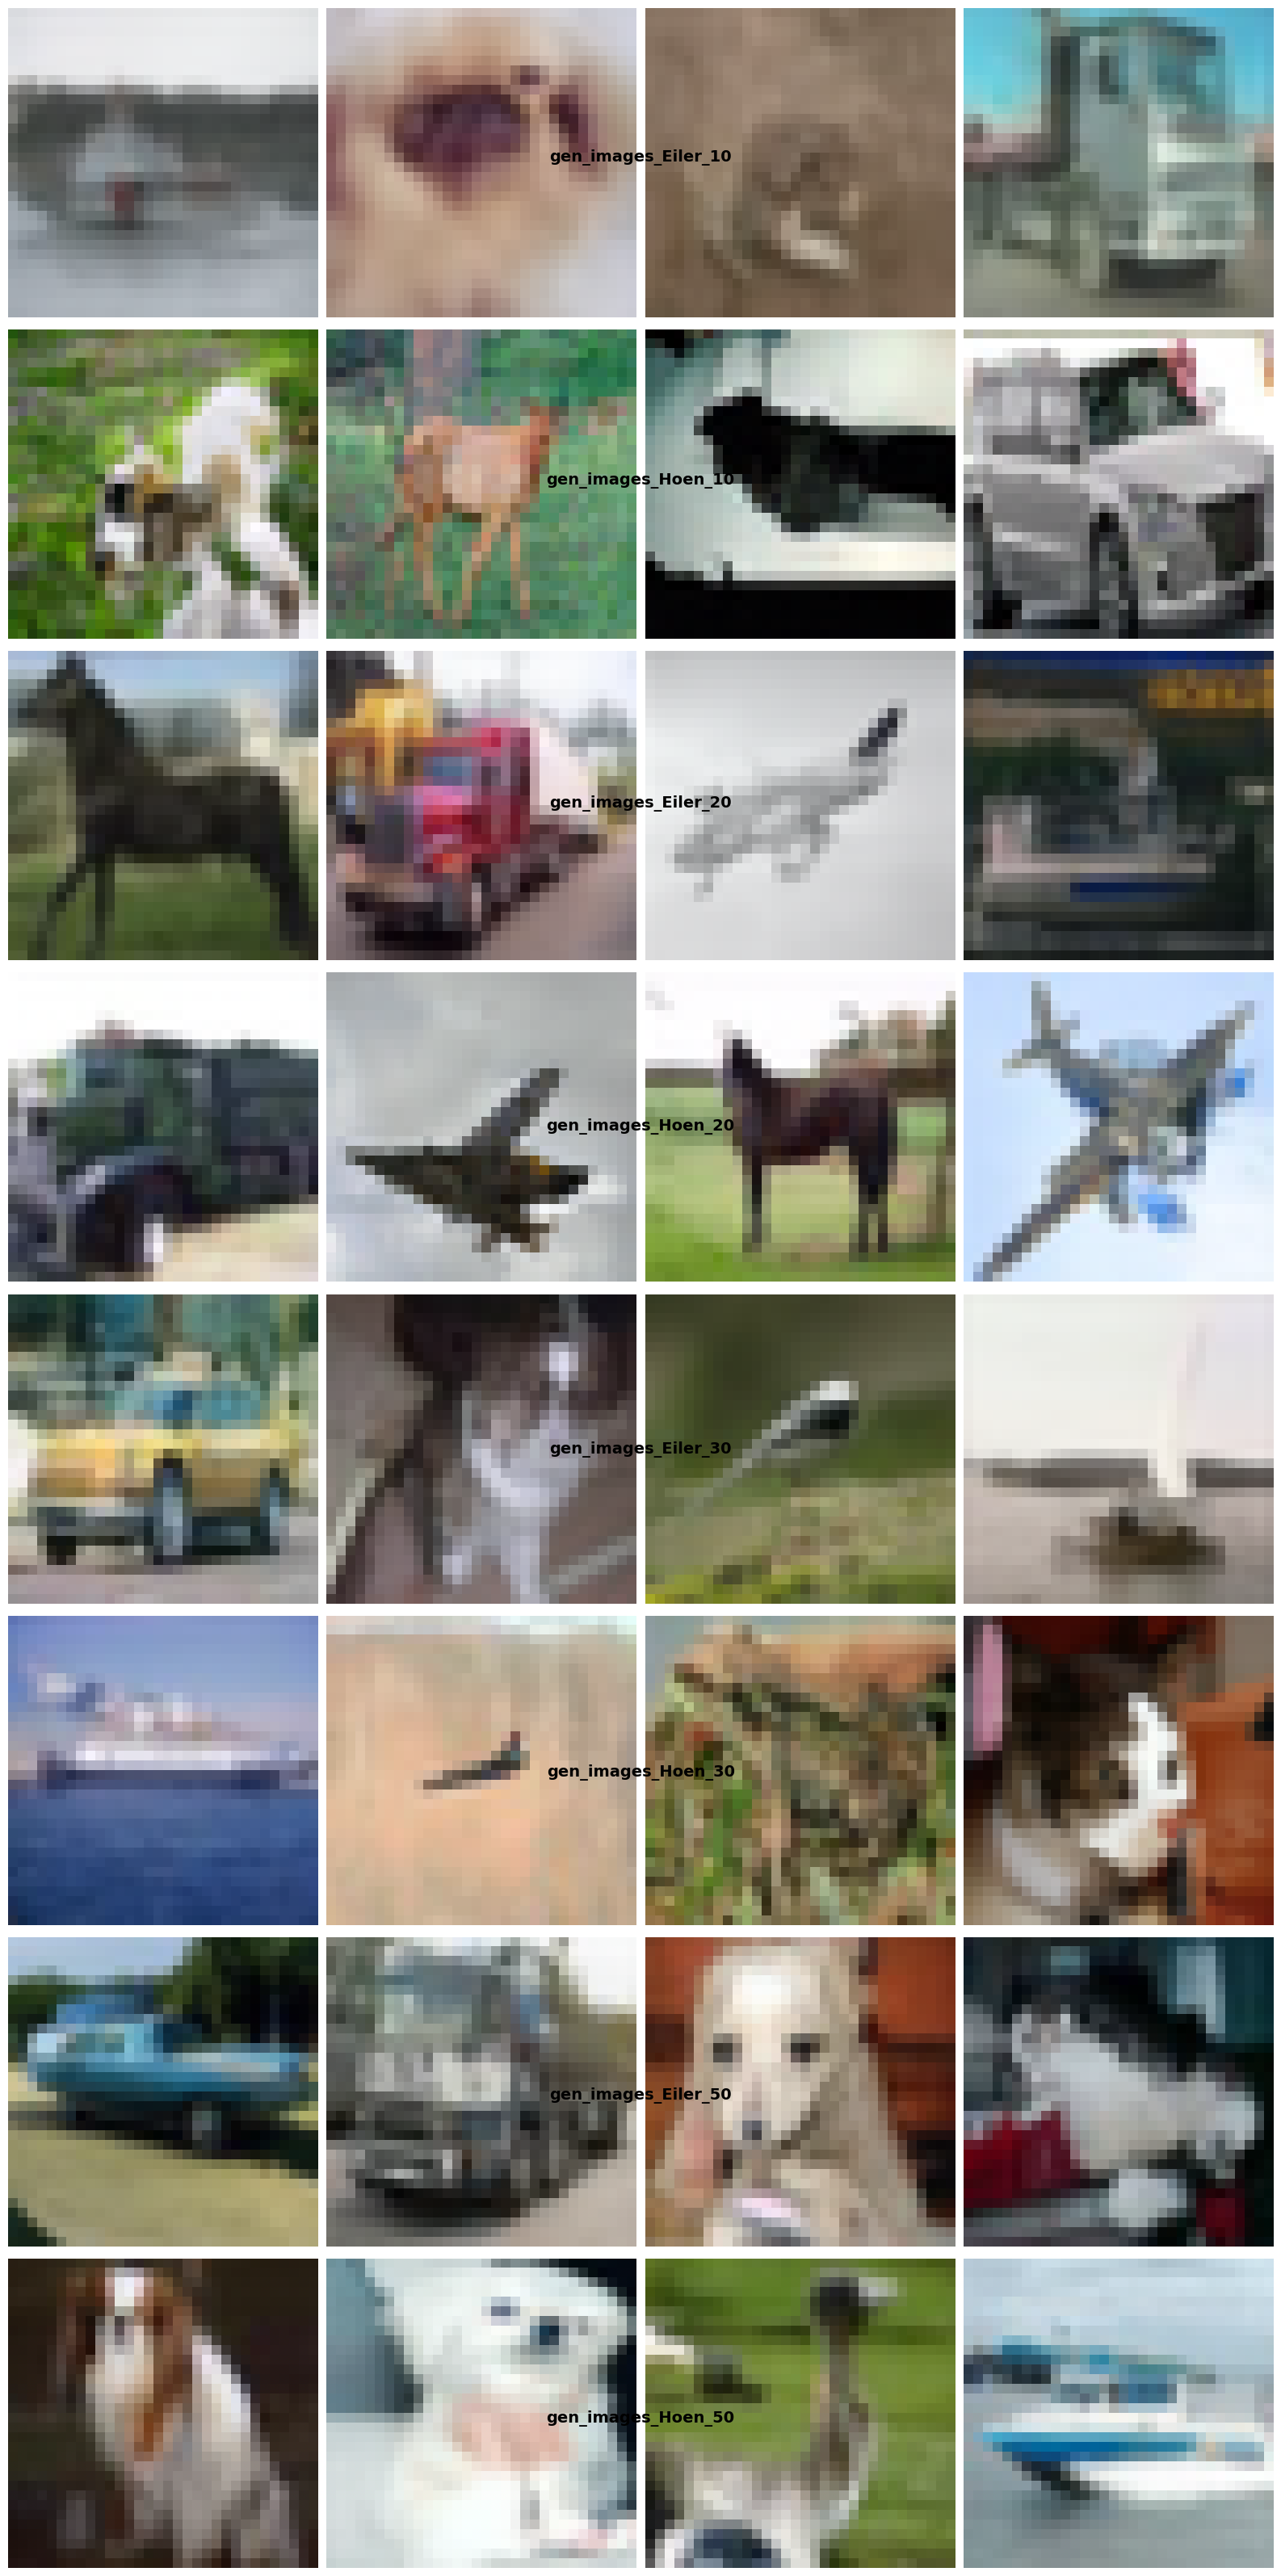

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Параметры для отображения
folders = ["gen_images_Eiler_10", "gen_images_Hoen_10", "gen_images_Eiler_20", "gen_images_Hoen_20",
           "gen_images_Eiler_30", "gen_images_Hoen_30", "gen_images_Eiler_50", "gen_images_Hoen_50"]
images_per_row = 4
fig = plt.figure(figsize=(16, len(folders) * 4))  # Размер для соответствия числу папок

# Итерация по папкам
for row, folder in enumerate(folders):
    # Получаем изображения из папки (до 4-х)
    image_files = os.listdir(folder)[:images_per_row]

    # Добавляем подпись папки
    fig.text(0.5, 1 - (row + 0.5) / len(folders), folder, ha='center', va='center', fontsize=14, fontweight='bold')

    for col, image_file in enumerate(image_files):
        img = Image.open(os.path.join(folder, image_file))

        # Создаем субплот на нужной позиции
        ax = fig.add_subplot(len(folders), images_per_row, row * images_per_row + col + 1)
        ax.imshow(img)
        ax.axis("off")

plt.tight_layout()
plt.show()